In [ ]:
!nvidia-smi
!pip install tensorflow==2.15.0 numpy
!pip install nvidia-pyindex
!pip install nvidia-tensorrt

Thu Mar  6 17:09:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, models, layers
import numpy as np

In [ ]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

170498071/170498071 [==============================] - 14s 0us/step


In [ ]:
#normalization
train_images = train_images.astype('float32')/255.0
test_images = test_images.astype('float32')/255.0

In [ ]:
#one_hot
train_labels = tf.keras.utils.to_categorical(train_labels,10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

In [ ]:
print("Train data shape:", train_images.shape)
print("Test data shape:", test_images.shape)

Train data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)


In [ ]:
# Build a simple CNN
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])


In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model (5 epochs to keep it quick)
history = model.fit(train_images, train_labels, epochs=5,
                    validation_data=(test_images, test_labels),
                    batch_size=64)

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.4f}")

Epoch 1/5
782/782 [==============================] - 44s 55ms/step - loss: 2.3028 - accuracy: 0.0976 - val_loss: 2.3033 - val_accuracy: 0.0931
Epoch 2/5
782/782 [==============================] - 42s 54ms/step - loss: 2.3027 - accuracy: 0.0981 - val_loss: 2.3032 - val_accuracy: 0.1001
Epoch 3/5
782/782 [==============================] - 44s 56ms/step - loss: 2.3027 - accuracy: 0.0980 - val_loss: 2.3033 - val_accuracy: 0.0976
Epoch 4/5
782/782 [==============================] - 44s 56ms/step - loss: 2.3027 - accuracy: 0.0977 - val_loss: 2.3031 - val_accuracy: 0.0977
Epoch 5/5
313/313 [==============================] - 3s 8ms/step - loss: 2.3034 - accuracy: 0.0998
Test accuracy: 0.0998


In [ ]:
# Save the model
model.save('cifar10_model')
print("Model saved to 'cifar10_model' directory")

Model saved to 'cifar10_model' directory


In [ ]:
import tensorflow as tf

# Load the original SavedModel
model = tf.keras.models.load_model('cifar10_model')

# Convert to TFLite with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Enables quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32

tflite_model = converter.convert()

# Save the TFLite model
with open('cifar10_model.tflite', 'wb') as f:
    f.write(tflite_model)
print("TFLite model saved to 'cifar10_model.tflite'")

TFLite model saved to 'cifar10_model.tflite'


In [ ]:
import tensorflow as tf
import numpy as np
import time

# Load original model
original_model = tf.keras.models.load_model('cifar10_model')

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path='cifar10_model.tflite')
interpreter.allocate_tensors()

# Get input and output tensor details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input shape expected by TFLite:", input_details[0]['shape'])
# test batch (first 64 images)
test_batch = test_images[:64].astype(np.float32)
# Time original model inference (batch of 64)
start_time = time.time()
original_preds = original_model.predict(test_batch)
original_time = time.time() - start_time
print(f"Original model inference time (batch of 64): {original_time:.4f} seconds")

# Time TFLite model inference (loop over 64 images)
tflite_time = 0
tflite_preds = []
for i in range(64):
    single_image = test_batch[i:i+1]
    start_time = time.time()
    interpreter.set_tensor(input_details[0]['index'], single_image)
    interpreter.invoke()
    pred = interpreter.get_tensor(output_details[0]['index'])
    tflite_time += time.time() - start_time
    tflite_preds.append(pred)

print(f"TFLite model inference time (64 individual inferences): {tflite_time:.4f} seconds")

# Calculate speedup (or slowdown) per image
original_time_per_image = original_time / 64
tflite_time_per_image = tflite_time / 64
speedup = (original_time_per_image - tflite_time_per_image) / original_time_per_image * 100
print(f"Per-image speedup: {speedup:.2f}%")

# Check model size reduction
import os
original_size = os.path.getsize('cifar10_model/saved_model.pb') / 1024
tflite_size = os.path.getsize('cifar10_model.tflite') / 1024
print(f"Original model size: {original_size:.2f} KB")
print(f"TFLite model size: {tflite_size:.2f} KB")

Input shape expected by TFLite: [ 1 32 32  3]
2/2 [==============================] - 0s 10ms/step
Original model inference time (batch of 64): 0.1476 seconds
TFLite model inference time (64 individual inferences): 0.0220 seconds
Per-image speedup: 85.12%
Original model size: 151.04 KB
TFLite model size: 130.23 KB


In [ ]:
original_preds = original_model.predict(test_batch)
tflite_preds = np.concatenate(tflite_preds, axis=0)
accuracy_drop = np.mean(np.argmax(original_preds, axis=1) != np.argmax(tflite_preds, axis=1))
print(f"Accuracy drop: {accuracy_drop:.2%}")

2/2 [==============================] - 0s 32ms/step
Accuracy drop: 0.00%


In [ ]:
full_tflite_preds = []
for i in range(len(test_images)):
    single_image = test_images[i:i+1].astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], single_image)
    interpreter.invoke()
    pred = interpreter.get_tensor(output_details[0]['index'])
    full_tflite_preds.append(pred)
full_tflite_preds = np.concatenate(full_tflite_preds, axis=0)
full_original_preds = original_model.predict(test_images)
accuracy_drop = np.mean(np.argmax(full_original_preds, axis=1) != np.argmax(full_tflite_preds, axis=1))
print(f"Full test set accuracy drop: {accuracy_drop:.2%}")

313/313 [==============================] - 3s 8ms/step
Full test set accuracy drop: 0.20%


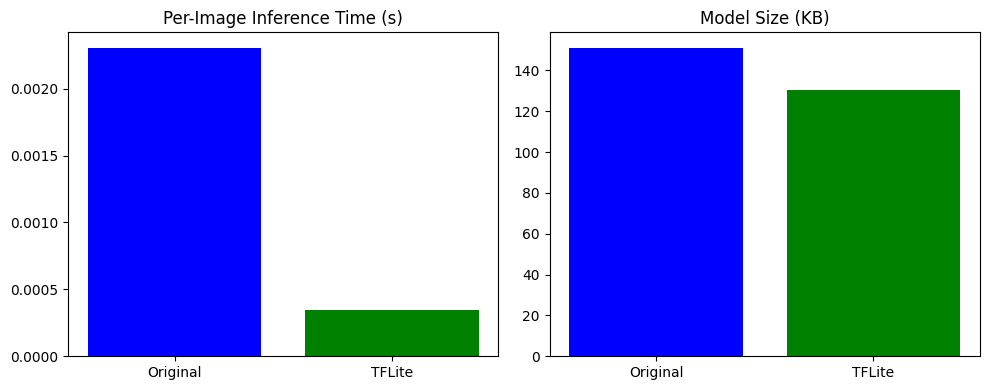

In [ ]:
import matplotlib.pyplot as plt

# Data
labels = ['Original', 'TFLite']
times = [0.002306, 0.000344]
sizes = [151.04, 130.23]

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.bar(labels, times, color=['blue', 'green'])
ax1.set_title('Per-Image Inference Time (s)')
ax2.bar(labels, sizes, color=['blue', 'green'])
ax2.set_title('Model Size (KB)')
plt.tight_layout()
plt.savefig('optimization_results.png')
plt.show()



In [28]:
from google.colab import files
files.download('cifar10_model')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>